<a href="https://colab.research.google.com/github/xdu006/COVID-Variant-Classifier/blob/main/ML_(COVID_variant_classifier).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#install dependencies
install.packages("rentrez")
install.packages("randomForest")

if (!require("BiocManager", quietly = TRUE)) install.packages("BiocManager")

BiocManager::install("Biostrings")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.23), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'Biostrings'”
Old packages: 'gert', 'Rcpp', 'tinytex', 'xfun'



In [21]:
#### LOAD LIBRARIES & SEARCH DATABASE----
# install.packages("Tidyverse", "ggpmisc") #install packages if needed

#load libraries
library("tidyverse")
library("rentrez")
library("Biostrings")
library("stringr")
library("randomForest")

#check databases & search terms available (only for process, thus commented out for output clarity)
#entrez_dbs()
#entrez_db_searchable(db = "nuccore")

#search for entries of each variant and save the search history
#search terms: ensure it is SARS-COV2, contains gene for S protein, RNA-based only (no DNA entries) for consistancy, and variant as indicated below
#VARIENTS: Alpha = B.1.1.7 (1000), Beta = B.1.351 (100), Delta = B.1.617.2 (500), Omicron = BA.1 (only original omicron lineage taken for simplicity) (according to https://cov-lineages.org/ PANGOLIN COVID lineage)
Alpha <- entrez_search(db = "nuccore", term = "Severe acute respiratory syndrome coronavirus 2[ORGN] AND surface glycoprotein[PROT] NOT DNA[ALL] AND B.1.1.7[ALL]", retmax = 1, use_history=TRUE)
Beta <- entrez_search(db = "nuccore", term = "Severe acute respiratory syndrome coronavirus 2[ORGN] AND surface glycoprotein[PROT] NOT DNA[ALL] AND B.1.351[ALL]", retmax = 1, use_history=TRUE)
Delta <- entrez_search(db = "nuccore", term = "Severe acute respiratory syndrome coronavirus 2[ORGN] AND surface glycoprotein[PROT] NOT DNA[ALL] AND B.1.617.2[ALL]", retmax = 1, use_history=TRUE)
Omicron <- entrez_search(db = "nuccore", term = "Severe acute respiratory syndrome coronavirus 2[ORGN] AND surface glycoprotein[PROT] NOT DNA[ALL] AND BA.1[ALL]", retmax = 1, use_history=TRUE)

#put variant names and search results into a list (iteratable later)
variant_results <- list(Alpha, Beta, Delta, Omicron)
variant_names <- list("Alpha", "Beta", "Delta", "Omicron")

#NOTE: number of entries varies as seen below. Max of 1000 entries taken from each group. (lack of entries may cause bias in machine learning model and cause more uncertain labeling)
#check total number of entries found for SARS-COV2 Alpha, Beta, Delta, Omicron respectively:
print("Total entries per variant: ")
print(c(Alpha$count, Beta$count, Delta$count, Omicron$count))

#NOTE: there is clear imbalance in the number of entries found. For the purposes of this classifier there are too few beta variant entries for complete undersampling and no extra data available from the database in our scope, thus we will accept the potential class imbalance bias and only undersample to 1500 entries max. One option we an try is to oversample by removing a random character from each Beta variant entry to artificially generate more data, however I ran out of time for this project.

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:BiocGenerics’:

    combine


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




[1] "Total entries per variant: "
[1] 2475   89  532 2864


Processing data set 1 ...Processing data set 2 ...Processing data set 3 ...Processing data set 4 ...Dataframe creation DONE

Variant,n
<chr>,<int>
Alpha,1344
Beta,86
Delta,514
Omicron,1500


[1] 0

.
2562 3687 3693 3702 3717 3726 3729 3750 3771 3786 3789 3801 3804 3807 3810 3813 
   6    1   21    2    5    1    1    1    2    2    1    1  669  250   11 1931 
3816 3819 3822 3831 3834 
 409   17  110    2    1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2562    3807    3813    3808    3813    3834 

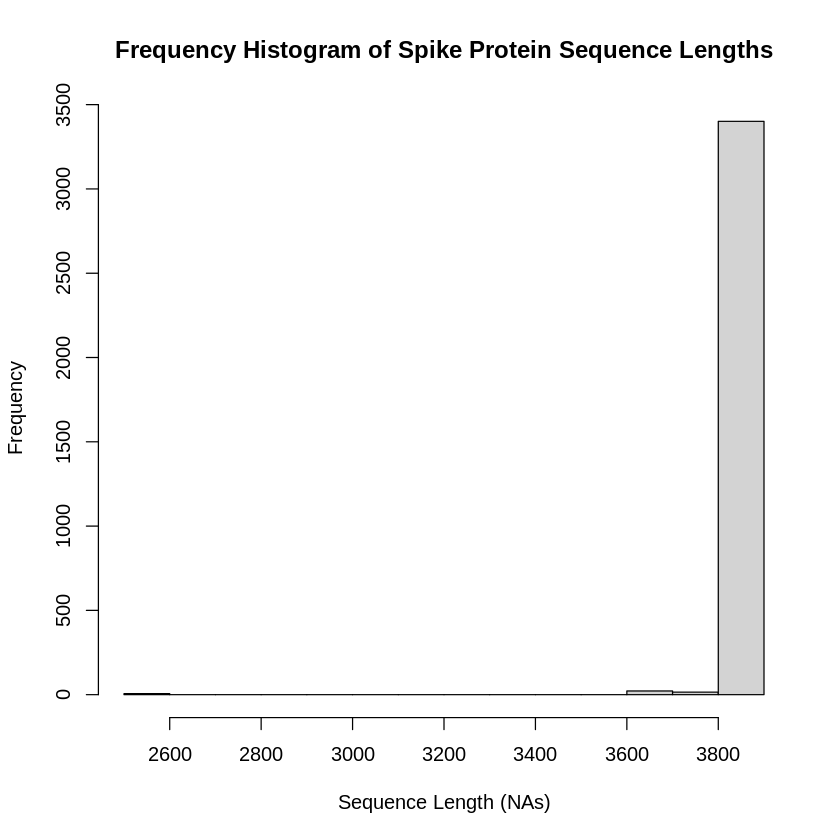

.
3687 3693 3702 3717 3726 3729 3750 3771 3786 3789 3801 3804 3807 3810 3813 3816 
   1   21    2    5    1    1    1    2    2    1    1  669  250   11 1931  409 
3819 3822 3831 3834 
  17  110    2    1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3687    3807    3813    3810    3813    3834 

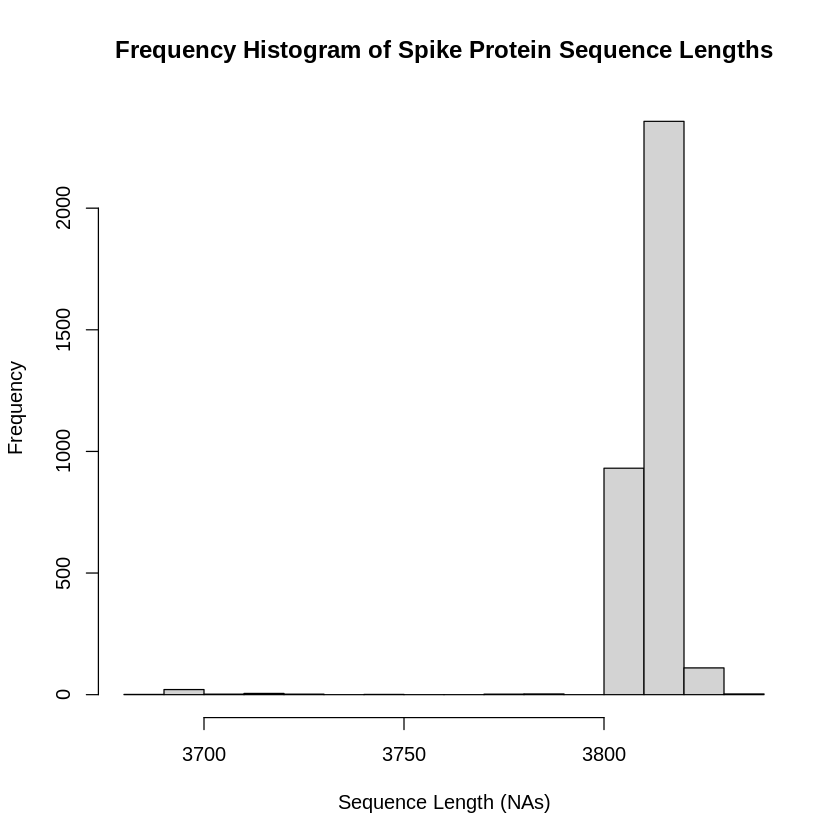

In [30]:
#### DOWNLOAD & CLEAN DATA----


#NOTE: many steps below are piped/looped to save memory/variable use, but can (and have been) be easily taken apart to test that they work as intended.


#initialize variables/counters
dfCOVFull=data.frame() #set up overall dataframe
i <- 1 #counter

#loop to fetch data for each variant (this section in the novel code component for data extraction)
for (variant_name in variant_names){

  #fetch (using browser history because too many files) all CDS from a set number of entries
  entrez_fetch(db = "nuccore", web_history=variant_results[[i]]$web_history, rettype = "fasta_cds_na", retmax=1500, use_history = TRUE) %>%
    #isolate only sequences (CDS) coding surface glycoprotein (spike protein) using regex
    str_extract_all(">[^\\]]+\\]\\s\\[protein\\=surface\\sglycoprotein[^>]+", simplify = TRUE) %>%
    #write to temporary file
    write("COV_S_proteins_temp.fasta", sep = "\n")

  #read as DNAStringSet
  stringSet <- readDNAStringSet("COV_S_proteins_temp.fasta")

  #convert our data to a dataframe with the correct variant type, remove empty sequences (due to regex searches) and append new set of data to the current set
  dfCOVFull <- data.frame(Variant=variant_name, id=names(stringSet), S_Sequence=paste(stringSet)) %>%
    #NOTE: above you can check id column to double check that regex extraction worked (should all be gene=S and protein=surface glycoprotein)
    filter(str_length(S_Sequence)>"100") %>%
    #NOTE: you can rehome the above step to outside the for loop to check number of sequences removed (but it is placed here to save memory for my computer)
    rbind(dfCOVFull) #append to dataframe

  i<- i+1 #increment counter
  cat("Processing data set",i-1,"...") #note for user
}

cat("Dataframe creation DONE") #note for user

#CHECK DATA

#some tests to ensure code working as expected
# View(dfCOVFull) #Optional view dataframe to check
# dfCOVFull[1,2] == dfCOVFull[11,2] #Check that values are not being replicated (on simplified model with retmax=10)


dfCOVFull %>% group_by(Variant) %>% count() #check the number of available data after simple processing
sum(is.na(dfCOVFull$S_Sequence)) #should be no NAs in data (All false (0), therefore sum = 0)

#check length of sequences to ensure they are more or less the same protein...
str_length(dfCOVFull$S_Sequence) %>% hist(xlab = "Sequence Length (NAs)", ylab = "Frequency", main = "Frequency Histogram of Spike Protein Sequence Lengths", )
str_length(dfCOVFull$S_Sequence) %>% table()
str_length(dfCOVFull$S_Sequence) %>% summary()
#NOTE: very good distribution, except clear outlier at 2562. Remove these datapoints.
dfCOVFull <- dfCOVFull %>% filter(str_count(S_Sequence) > 3000)

#check again, looks good!
str_length(dfCOVFull$S_Sequence) %>% hist(xlab = "Sequence Length (NAs)", ylab = "Frequency", main = "Frequency Histogram of Spike Protein Sequence Lengths", )
str_length(dfCOVFull$S_Sequence) %>% table()
str_length(dfCOVFull$S_Sequence) %>% summary()

In [31]:
#### RANDOM FOREST DATA PROCESSING & DISTANCE MEASURES----

#process data for RandomForest (remove beginning and trailing Ns, gap indicators, and limit number of Ns to <10%)
dfCOVFull <- dfCOVFull %>%
  mutate(S_Sequence2 = str_remove(S_Sequence, "^[-N]+")) %>%
  mutate(S_Sequence2 = str_remove(S_Sequence2, "[-N]+$")) %>%
  mutate(S_Sequence2 = str_remove_all(S_Sequence2, "-+")) %>%
  filter(str_count(S_Sequence2, "N") < (0.1 * str_count(S_Sequence))) #keep sequences with <10% Ns

#check amount of remaining data (still imbalanced as expected)
dfCOVFull %>% group_by(Variant) %>% count()


#CALCULATE DISTANCE MEASURES

#convert to DNA stringset to work with
dfCOVFull$S_Sequence2 <- DNAStringSet(dfCOVFull$S_Sequence2)

#1) ATG PROP

#find letter frequency and put into new columns
dfCOVFull <- cbind(dfCOVFull, as.data.frame(letterFrequency(dfCOVFull$S_Sequence2, letters = c("A", "C","G", "T"))))
#calculate proportions of each
dfCOVFull$Aprop <- (dfCOVFull$A) / (dfCOVFull$A + dfCOVFull$T + dfCOVFull$C + dfCOVFull$G)
dfCOVFull$Tprop <- (dfCOVFull$T) / (dfCOVFull$A + dfCOVFull$T + dfCOVFull$C + dfCOVFull$G)
dfCOVFull$Gprop <- (dfCOVFull$G) / (dfCOVFull$A + dfCOVFull$T + dfCOVFull$C + dfCOVFull$G)

dfCOVFull <- dfCOVFull[1:11]

#2) KMER OF 2, 3, and 4

dfCOVFull <- cbind(dfCOVFull, as.data.frame(dinucleotideFrequency(dfCOVFull$S_Sequence2, as.prob = TRUE)))
dfCOVFull <- cbind(dfCOVFull, as.data.frame(trinucleotideFrequency(dfCOVFull$S_Sequence2, as.prob = TRUE)))
dfCOVFull <- cbind(dfCOVFull, as.data.frame(oligonucleotideFrequency(x = dfCOVFull$S_Sequence2, width = 4, as.prob = TRUE)))

#convert back into char
dfCOVFull$S_Sequence2 <- as.character(dfCOVFull$S_Sequence2)

Variant,n
<chr>,<int>
Alpha,1303
Beta,69
Delta,460
Omicron,1026


In [32]:
#### TRAINING/VALIDATION DATA SEPERATION----

#ensure repeatable results
set.seed(217)

#20% of data in each group/variant should be validation data
dfValidation <- dfCOVFull %>%
  group_by(Variant) %>%
  sample_frac(0.2)

#the other 80% is used for training
dfTraining <- dfCOVFull %>%
  filter(!id %in% dfValidation$id) %>%
  group_by(Variant) %>%
  sample_frac(0.8)

#check amount of training and validation data
dfValidation %>% group_by(Variant) %>% count()
dfTraining %>% group_by(Variant) %>% count()

#set accuracy function for validation later
accuracy <- function(x){sum(diag(x)/(sum(rowSums(x)))) * 100} #overall accuracy
accuracyPerVariant <- function(x){diag(x)/(rowSums(x)) * 100} #accuracy by variant
accuracyWeighted <- function(x){sum(diag(x)/(rowSums(x)))/4 * 100} #accuracy weighted equally for each variant (average of accuracy by variant)


Variant,n
<chr>,<int>
Alpha,261
Beta,14
Delta,92
Omicron,205


Variant,n
<chr>,<int>
Alpha,834
Beta,44
Delta,294
Omicron,657


In [33]:
#### RANDOM FOREST 1 (ATG) ----

set.seed(200) #reproducible results

#BUILD CLASSIFIER

gene_classifier <- randomForest::randomForest(x = dfTraining[, 9:11], y = as.factor(dfTraining$Variant), ntree = 50, importance = TRUE)

#EVALUATE

#training
gene_classifier #check error rate estimate
#NOTE: from confusion matrix, we can see there is higher error for the undersampled groups as expected (beta and delta)

#validation
predictValidation <- predict(gene_classifier, dfValidation[, c(1, 9:11)])
tab <- table(observed = dfValidation$Variant, predicted = predictValidation) #validation confusion matrix
tab

#check actual prediction accuracy
accuracy(tab)
accuracyPerVariant(tab)
accuracyWeighted(tab)
#90.2% accuracy, pretty good for first try! but weighted accuracy is quite low due to beta group
#again, as we can see, there is higher error for the undersampled groups (beta and delta)



Call:
 randomForest(x = dfTraining[, 9:11], y = as.factor(dfTraining$Variant),      ntree = 50, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 1

        OOB estimate of  error rate: 10.61%
Confusion matrix:
        Alpha Beta Delta Omicron class.error
Alpha     758    8    26      42  0.09112710
Beta       15   24     1       4  0.45454545
Delta      25    0   232      37  0.21088435
Omicron    22    2    12     621  0.05479452

         predicted
observed  Alpha Beta Delta Omicron
  Alpha     242    2     6      11
  Beta        6    7     0       1
  Delta      15    0    67      10
  Omicron     7    0     2     196

[1] 89.51049

Alpha     Beta    Delta  Omicron 
92.72031 50.00000 72.82609 95.60976

[1] 77.78904

In [34]:
#### RANDOM FOREST 2 (KMER2) ----

#BUILD CLASSIFIER

#note using default ntree=50 as a simple assessment first
gene_classifier <- randomForest::randomForest(x = dfTraining[, 12:27], y = as.factor(dfTraining$Variant), ntree = 50, importance = TRUE)

#EVALUATE

#training
gene_classifier #check error rate estimate
#NOTE: from confusion matrix, we can see there is higher error for the undersampled groups as expected (beta and delta)

#validation
predictValidation <- predict(gene_classifier, dfValidation[, c(1, 12:27)])
tab <- table(observed = dfValidation$Variant, predicted = predictValidation) #validation confusion matrix
tab

#check actual prediction accuracy
accuracy(tab)
accuracyPerVariant(tab)
accuracyWeighted(tab)
#much higher accuracy!! 97.7% overall and 92.3% weighted. Beta still lagging behing at only 78% accuracy.


Call:
 randomForest(x = dfTraining[, 12:27], y = as.factor(dfTraining$Variant),      ntree = 50, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 4

        OOB estimate of  error rate: 2.95%
Confusion matrix:
        Alpha Beta Delta Omicron class.error
Alpha     821    0     6       7  0.01558753
Beta        9   34     1       0  0.22727273
Delta      12    0   267      15  0.09183673
Omicron     3    0     1     653  0.00608828

         predicted
observed  Alpha Beta Delta Omicron
  Alpha     257    1     0       3
  Beta        2   11     0       1
  Delta       2    0    85       5
  Omicron     0    0     3     202

[1] 97.02797

Alpha     Beta    Delta  Omicron 
98.46743 78.57143 92.39130 98.53659

[1] 91.99169

In [35]:
#### RANDOM FOREST 3 (KMER3) ----

#BUILD CLASSIFIER

gene_classifier <- randomForest::randomForest(x = dfTraining[, 28:91], y = as.factor(dfTraining$Variant), ntree = 50, importance = TRUE)

#EVALUATE

#training
gene_classifier #check error rate estimate
#NOTE: from confusion matrix, we can see there is higher error for the undersampled groups as expected (beta and delta)

#validation
predictValidation <- predict(gene_classifier, dfValidation[, c(1, 28:91)])
tab <- table(observed = dfValidation$Variant, predicted = predictValidation) #validation confusion matrix
tab

#check actual prediction accuracy
accuracy(tab)
accuracyPerVariant(tab)
accuracyWeighted(tab)
#wow, 100% accuracy for alpha and beta variants! Beta and delta still lagging behind, causing overall accuracy of 98.9 and weighted accuracy to be 95.3. Beta at 85.7%



Call:
 randomForest(x = dfTraining[, 28:91], y = as.factor(dfTraining$Variant),      ntree = 50, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 8

        OOB estimate of  error rate: 1.48%
Confusion matrix:
        Alpha Beta Delta Omicron class.error
Alpha     832    0     1       1 0.002398082
Beta        7   37     0       0 0.159090909
Delta       6    0   278      10 0.054421769
Omicron     0    0     2     655 0.003044140

         predicted
observed  Alpha Beta Delta Omicron
  Alpha     260    0     1       0
  Beta        2   12     0       0
  Delta       0    0    87       5
  Omicron     0    0     0     205

[1] 98.6014

Alpha      Beta     Delta   Omicron 
 99.61686  85.71429  94.56522 100.00000

[1] 94.97409

In [27]:
#### RANDOM FOREST 4 (KMER4) ----

#BUILD CLASSIFIER

gene_classifier <- randomForest::randomForest(x = dfTraining[, 92:347], y = as.factor(dfTraining$Variant), ntree = 50, importance = TRUE)

#EVALUATE

#training
gene_classifier #check error rate estimate
#NOTE: from confusion matrix, we can see there is higher error for the undersampled groups as expected (beta and delta)

#validation
predictValidation <- predict(gene_classifier, dfValidation[, c(1, 92:347)])
tab <- table(observed = dfValidation$Variant, predicted = predictValidation) #validation confusion matrix
tab

#check actual prediction accuracy
accuracy(tab)
accuracyPerVariant(tab)
accuracyWeighted(tab)
#not much difference here, we have reached the limit to how well we can differentiate these variants based on poor class balance for random forest (we will no longe rbe looking at kmer 4)
#interestingly, same confusion matrix as kmer3. Perhaps those few inaccurate sequences have differences that make them difficult to group? Could they represent transition states between alpha-beta (etc.) variants? Very interesting questions for the future and also great way to examine the evolution of COVID spike proteins


Call:
 randomForest(x = dfTraining[, 92:347], y = as.factor(dfTraining$Variant),      ntree = 50, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 16

        OOB estimate of  error rate: 1.09%
Confusion matrix:
        Alpha Beta Delta Omicron class.error
Alpha     834    0     0       0  0.00000000
Beta        5   38     1       0  0.13636364
Delta       4    0   281       9  0.04421769
Omicron     1    0     0     656  0.00152207

         predicted
observed  Alpha Beta Delta Omicron
  Alpha     261    0     0       0
  Beta        2   12     0       0
  Delta       0    0    87       5
  Omicron     0    0     0     205

[1] 98.77622

Alpha      Beta     Delta   Omicron 
100.00000  85.71429  94.56522 100.00000

[1] 95.06988

In [28]:
#### K-NN () ----

#import library
library(class)

#normalization function
nor <-function(x) { (x -min(x))/(max(x)-min(x))   }

set.seed(200)

#BUILD CLASSIFIER (ATG)

#normalize training and validation data
dfValidationNorm <- as.data.frame(lapply(dfValidation[,c(9:11)], nor))
dfTrainingNorm <- as.data.frame(lapply(dfTraining[,c(9:11)], nor))

#create prediction classifier, use k=9 (various k were tried: recommended sqrt of all data did not work, but sqrt of smallest stat group works well! (9*9=81 == approx beta data size))
pr <- knn(train = dfTrainingNorm, test = dfValidationNorm, cl = dfTraining$Variant, k=9)

#confustion matrix
tab <- table(dfValidation$Variant, pr)
tab

#check actual prediction accuracy
accuracy(tab)
accuracyPerVariant(tab)
accuracyWeighted(tab)
#interestingly more poorly predicting for delta than beta...

#BUILD CLASSIFIER (KMER2)

#normalize training and validation data
dfValidationNorm <- as.data.frame(lapply(dfValidation[,c(12:27)], nor))
dfTrainingNorm <- as.data.frame(lapply(dfTraining[,c(12:27)], nor))
#create prediction classifier, use k=9 (various k were tried: recommended sqrt of all data did not work, but sqrt of smallest stat group works well! (9*9=81 == approx beta data size))
pr <- knn(train = dfTrainingNorm, test = dfValidationNorm, cl = dfTraining$Variant, k=9)
#confusion matrix
tab <- table(dfValidation$Variant, pr)
tab
#check actual prediction accuracy
accuracy(tab)
accuracyPerVariant(tab)
accuracyWeighted(tab)
# overall 97.4, 92.2 weighted, beta performed most poorly at 78.6

#BUILD CLASSIFIER (KMER3)

#normalize training and validation data
dfValidationNorm <- as.data.frame(lapply(dfValidation[,c(28:91)], nor))
dfTrainingNorm <- as.data.frame(lapply(dfTraining[,c(28:91)], nor))
#create prediction classifier, use k=9 (various k were tried: recommended sqrt of all data did not work, but sqrt of smallest stat group works well! (9*9=81 == approx beta data size))
pr <- knn(train = dfTrainingNorm, test = dfValidationNorm, cl = dfTraining$Variant, k=9)
#confustion matrix
tab <- table(dfValidation$Variant, pr)
tab
#check actual prediction accuracy
accuracy(tab)
accuracyPerVariant(tab)
accuracyWeighted(tab)
#higher accuracy: 98.8 overall, 96.9 weighted, beta at 92.6 (Better than Rand forest for class imbalance!)

         pr
          Alpha Beta Delta Omicron
  Alpha       7   11     1     242
  Beta        1    9     0       4
  Delta       6    2     4      80
  Omicron     1    1     1     202

[1] 38.81119

Alpha      Beta     Delta   Omicron 
 2.681992 64.285714  4.347826 98.536585

[1] 42.46303

         pr
          Alpha Beta Delta Omicron
  Alpha     258    1     0       2
  Beta        3   11     0       0
  Delta      10    0    78       4
  Omicron     0    0     2     203

[1] 96.15385

Alpha     Beta    Delta  Omicron 
98.85057 78.57143 84.78261 99.02439

[1] 90.30725

         pr
          Alpha Beta Delta Omicron
  Alpha     260    0     1       0
  Beta        1   13     0       0
  Delta       3    0    88       1
  Omicron     0    0     0     205

[1] 98.95105

Alpha      Beta     Delta   Omicron 
 99.61686  92.85714  95.65217 100.00000

[1] 97.03154

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: usethis


Attaching package: ‘devtools’


The following object is masked from ‘package:BiocManager’:

    install






── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpSjzUks/remotes1511238975/munoztd0-reprtree-583b8a3/DESCRIPTION’ ... OK
* preparing ‘reprtree’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘reprtree_0.6.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Registered S3 method overwritten by 'reprtree':
  method    from
  text.tree tree



ntree      OOB      1      2      3      4
  100:  17.77% 16.55% 81.82% 28.23% 10.35%



Call:
 randomForest(formula = Variant ~ ., data = dfTrainingModel, ntree = 100,      importance = TRUE, do.trace = 100) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 1

        OOB estimate of  error rate: 17.77%
Confusion matrix:
    A B   D   O class.error
A 696 8  68  62   0.1654676
B  33 8   1   2   0.8181818
D  24 0 211  59   0.2823129
O  30 0  38 589   0.1035008

ntree      OOB      1      2      3      4
  100:   3.94%  1.68% 25.00% 11.90%  1.83%



Call:
 randomForest(formula = Variant ~ ., data = dfTrainingModel, ntree = 100,      importance = TRUE, do.trace = 100) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 4

        OOB estimate of  error rate: 3.94%
Confusion matrix:
    A  B   D   O class.error
A 820  0   7   7  0.01678657
B   6 33   4   1  0.25000000
D  13  1 259  21  0.11904762
O   5  0   7 645  0.01826484

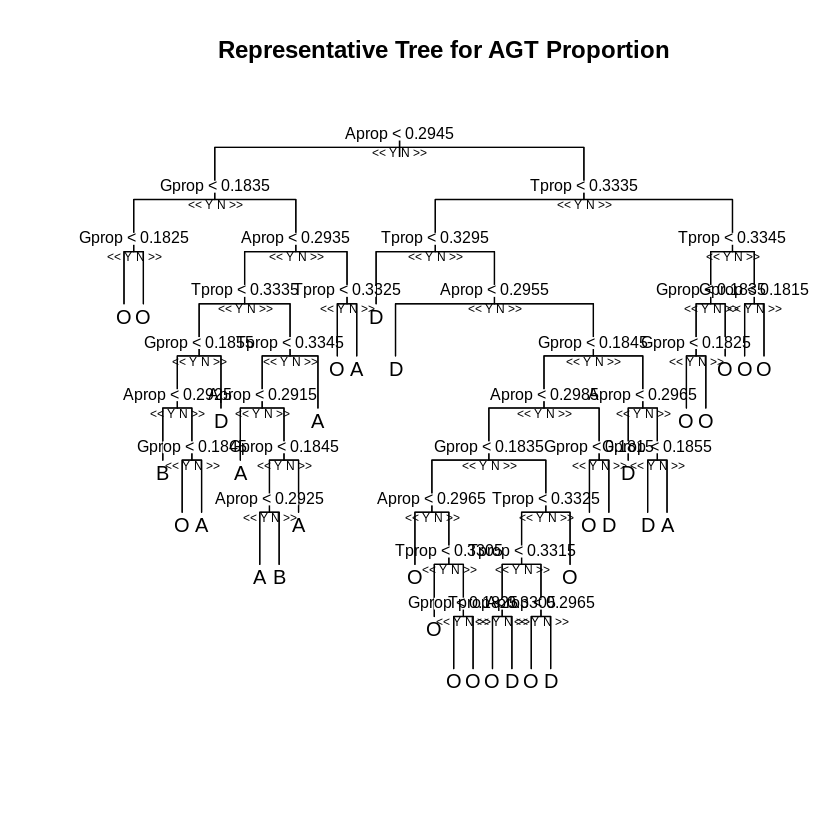

ntree      OOB      1      2      3      4
  100:   1.37%  0.00% 13.64%  6.12%  0.15%



Call:
 randomForest(formula = Variant ~ ., data = dfTrainingModel, ntree = 100,      importance = TRUE, do.trace = 100) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 8

        OOB estimate of  error rate: 1.37%
Confusion matrix:
    A  B   D   O class.error
A 834  0   0   0  0.00000000
B   6 38   0   0  0.13636364
D   7  0 276  11  0.06122449
O   1  0   0 656  0.00152207

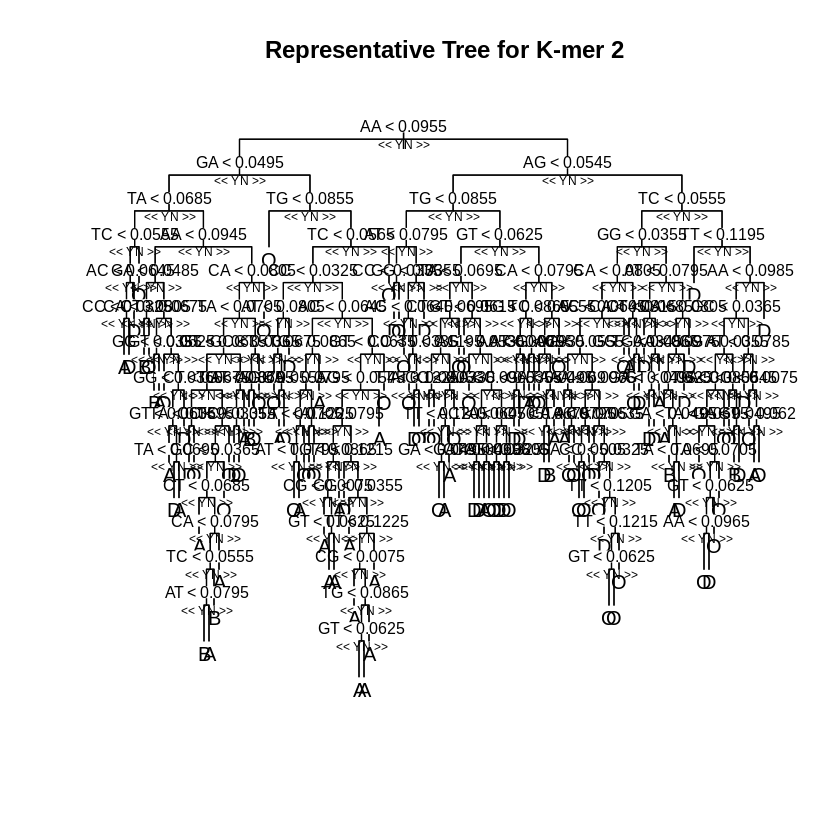

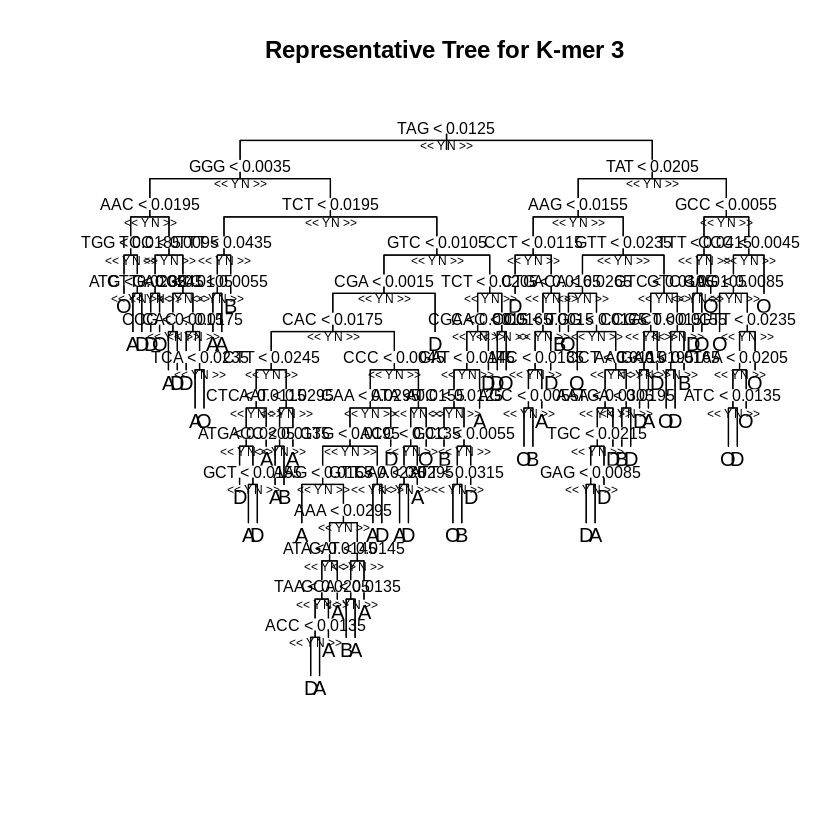

In [29]:
#### VISUALIZATION 1: Representative tree ----

#installation (from https://stats.stackexchange.com/questions/41443/how-to-actually-plot-a-sample-tree-from-randomforestgettree)
options(repos='http://cran.rstudio.org')
have.packages <- installed.packages()
cran.packages <- c('devtools','plotrix','randomForest','tree')
to.install <- setdiff(cran.packages, have.packages[,1])
if(length(to.install)>0) install.packages(to.install)

#load libraries
library(devtools)
if(!('reprtree' %in% installed.packages())){install_github('munoztd0/reprtree')}
for(p in c(cran.packages, 'reprtree')) eval(substitute(library(pkg), list(pkg=p)))


library(randomForest)
library(reprtree)

#draw tree for random forest ATG (for simplicity)
set.seed(500)
dfTrainingModel <- round(dfTraining[, 9:11], 3) #round smaller so we can see in tree visual.
dfTrainingModel$Variant <- as.factor(substr(dfTraining$Variant, 1, 1)) #take only first letter of variants so we can see in visual
model <- randomForest(Variant ~ ., data=dfTrainingModel,  ntree = 100, importance = TRUE, do.trace = 100) #train model
model
reprtree::plot.getTree(model, main="Representative Tree for AGT Proportion") #draw tree

#repeat for KMER2
set.seed(500)
dfTrainingModel <- round(dfTraining[, 12:27], 3)
dfTrainingModel$Variant <- as.factor(substr(dfTraining$Variant, 1, 1))
model <- randomForest(Variant ~ ., data=dfTrainingModel,  ntree = 100, importance = TRUE, do.trace = 100)
model
reprtree::plot.getTree(model, main="Representative Tree for K-mer 2")

#repeat for KMER 3
set.seed(500)
dfTrainingModel <- round(dfTraining[, 28:91], 3)
dfTrainingModel$Variant <- as.factor(substr(dfTraining$Variant, 1, 1))
model <- randomForest(Variant ~ ., data=dfTrainingModel,  ntree = 100, importance = TRUE, do.trace = 100)
model
reprtree::plot.getTree(model, main="Representative Tree for K-mer 3")

